```
This notebook tests the projected files for the Oslofjord
Copyright (C) 2022 - 2023 SINTEF Digital
Copyright (C) 2022 - 2023 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 26b98e82e8d4e1ca2369cf735af8c7d3af460403 on branch reduced_gravity


# Oslofjord
Testing of Nils projected files

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [4]:
%cuda_context_handler gpu_ctx

Path to the test file

In [5]:
source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"

## Inspecting file structure and content

In [6]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 720, s_rho: 42, s_w: 43, eta_rho: 741, xi_rho: 397, xi_u: 396, eta_v: 740)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2014-06-30T13:00:00 ... 2014-07-3...
  * s_rho       (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
  * s_w         (s_w) float64 -1.0 -0.9762 -0.9524 ... -0.04762 -0.02381 0.0
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/15)
    projection  int32 ...
    Cs_r        (s_rho) float64 ...
    Cs_w        (s_w) float64 ...
    h           (eta_rho, xi_rho) float32 ...
    mask_rho    (eta_rho, xi_rho) float32 ...
    angle       (eta_rho, xi_rho) float32 ...
    ...          ...
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 ...
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 ...
    lat_rho     (eta_rho, xi_rho) float32 ...
    lon_rho     (eta_rho, xi_rho) float32 ...

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  # Remove the CWD from sys.path while we load stuff.


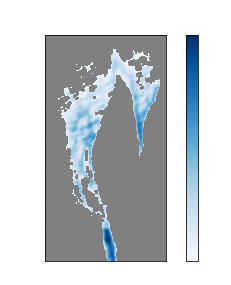

In [7]:
from netCDF4 import Dataset
nc = Dataset(source_url)

H_m = np.ma.array(nc["h"][1:-1,1:-1], mask=(1-nc["mask_rho"][1:-1,1:-1]))

fig, ax = plt.subplots()
fig.suptitle("Bathymetry")

cmap = plt.cm.Blues
cmap.set_bad("grey", alpha = 1.0)
im = ax.imshow(H_m, cmap=cmap)

plt.colorbar(im, ax=ax)
plt.tight_layout()

Animation utils

In [8]:
sys.path.append(os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir)))
from utils import animation_utils

## Generating GPUOcean Simulation from Input

In [9]:
dimY, dimX = ds.h.data.shape

In [10]:
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

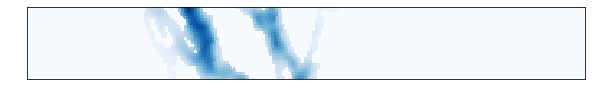

In [11]:
fig, ax = plt.subplots(figsize=(10,20))
ax.imshow(nc["h"][y0:y1, x0:x1][:50,:], interpolation="none", cmap="Blues")

In [12]:
data_args = {}

In [13]:
import pyproj
proj_str = nc["projection"].proj4

proj = pyproj.Proj(proj_str)

lat_rho = nc.variables['lat_rho'][y0:y1, x0:x1]
lon_rho = nc.variables['lon_rho'][y0:y1, x0:x1]
x_rho, y_rho = proj(lon_rho, lat_rho, inverse = False)
x, y = x_rho[0], y_rho[:,0]

data_args['nx'] = (x1-x0)-4
data_args['ny'] = (y1-y0)-4

NX = data_args["nx"]+4
NY = data_args["ny"]+4

data_args['dx'] = np.average(x[1:] - x[:-1])
data_args['dy'] = np.average(y[1:] - y[:-1])

In [14]:
data_args["dx"], data_args["dy"]

(49.99992641175269, 50.000104021367484)

In [15]:
data_args['angle'] = nc["angle"][y0:y1, x0:x1]
from gpuocean.utils import OceanographicUtilities
data_args['latitude'] = OceanographicUtilities.degToRad(lat_rho)
data_args["f"] = 0.0

Check Mixed-Layer Depth

In [16]:
t=5*24 + 11 # INPUT

In [17]:
mld = NetCDFInitialization.MLD(source_url, 1024, min_mld=1.5, max_mld=40, x0=x0, x1=x1, y0=y0, y1=y1, t=t)
backup_mld = copy.deepcopy(mld)

In [18]:
# FIXME!!!
# mld = NetCDFInitialization.correct_coastal_MLD(mld, source_url, coords=[x0,x1,y0,y1], rel_tol=0.25, abs_tol=1, land_value=0.0)

mld = NetCDFInitialization.fill_coastal_data(mld)

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  


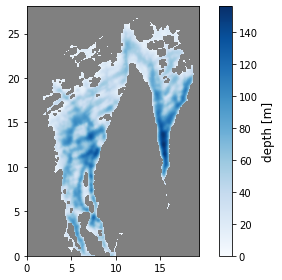

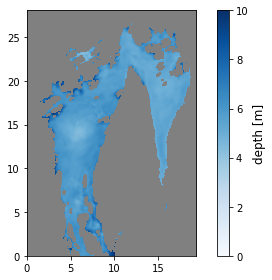

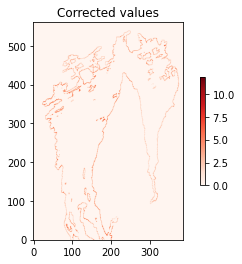

In [19]:
cmap = plt.cm.Blues
cmap.set_bad("grey", alpha = 1.0)

domain_extent = [0, mld.shape[1]*50/1000, 0, mld.shape[0]*50/1000]

with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    fig, ax = plt.subplots()
    im = ax.imshow(np.ma.array(nc["h"][y0:y1,x0:x1], mask=(nc["h"][y0:y1,x0:x1]==0)), 
                   vmin=0,
                   cmap=cmap, extent=domain_extent)
    cb = plt.colorbar(im, ax=ax, shrink=1)
    cb.set_label(label="depth [m]", size=12)
    plt.tight_layout()
    plt.savefig("figs/Oslofjord-bathymetry.pdf", dpi=200)


    fig, ax = plt.subplots()
    im = ax.imshow(mld, 
                    vmin=0, vmax=10,
                    cmap=cmap, extent=domain_extent)
    cb = plt.colorbar(im, ax=ax, shrink=1)
    cb.set_label(label="depth [m]", size=12)
    plt.tight_layout()
    plt.savefig("figs/Oslofjord-mld.pdf", dpi=200)


    fig, ax = plt.subplots()
    im = ax.imshow(np.abs(mld.data - backup_mld.data), cmap="Reds")
    plt.colorbar(im, ax=ax, shrink=0.5)
    ax.set_title("Corrected values")


Check densities

In [20]:
y_cut = 120

2014-07-06 00:00:00


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))


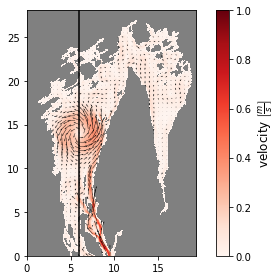

In [21]:
H_m = nc["h"][y0:y1,x0:x1]

u = 0.5*(nc["u"][t,:,y0:y1,x0:x1]+nc["u"][t,:,y0:y1,x0+1:x1+1])
v = 0.5*(nc["v"][t,:,y0:y1,x0:x1]+nc["v"][t,:,y0+1:y1+1,x0:x1])

integrator = NetCDFInitialization.MLD_integrator(source_url, mld, x0=x0, x1=x1, y0=y0, y1=y1)
hu = np.ma.array(np.sum(integrator * u, axis=0), mask=1-nc["mask_rho"][y0:y1,x0:x1])
hv = np.ma.array(np.sum(integrator * v, axis=0), mask=1-nc["mask_rho"][y0:y1,x0:x1])

u = hu/mld
v = hv/mld
velocity = np.sqrt(u*u + v*v)

ny, nx = velocity.shape
dx, dy = 0.050, 0.050
domain_extent = [0, nx*dx, 0, ny*dy]

frequency_x = 10
frequency_y = 10
x = np.arange(0, velocity.shape[1], frequency_x)*dx
y = np.arange(0, velocity.shape[0], frequency_y)*dy
qu = u[::frequency_y, ::frequency_x]
qv = v[::frequency_y, ::frequency_x]


with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    fig, ax = plt.subplots()

    # ax.tick_params(colors='black')
    ax.xaxis.label.set_color('black')

    velo_cmap = plt.cm.Reds
    velo_cmap.set_bad("grey", alpha = 1.0)

    im = ax.imshow(velocity, interpolation="none", origin='lower', 
                        cmap=velo_cmap,
                        vmin=0, vmax=1.0,
                        extent=domain_extent)
    ax.quiver(x,y,qu,qv, scale=5)

    cb = plt.colorbar(im, ax=ax, shrink=1)
    cb.set_label(label="velocity $\left[ \\frac{m}{s} \\right]$", size=12)
    
    ax.axvline(x=y_cut*dx, c="black")

    plt.tight_layout()

    # plt.savefig("figs/PotDensLine.pdf", dpi=200)

print(str(datetime.datetime.utcfromtimestamp(nc["ocean_time"][t]).strftime('%Y-%m-%d %H:%M:%S')))


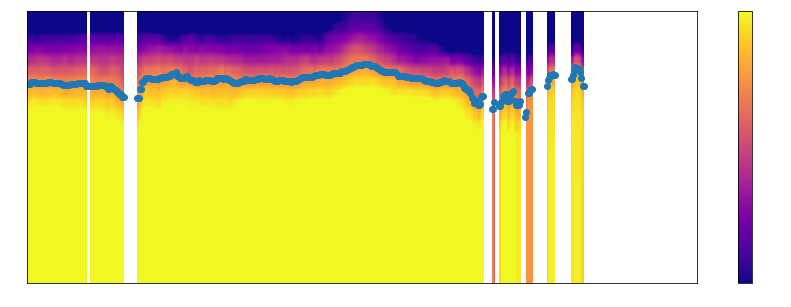

In [22]:
s_pot_densities = NetCDFInitialization.potentialDensities(source_url, t=t, x0=x0, x1=x1, y0=y0, y1=y1)

s_nc = Dataset(source_url)
s_hs   = s_nc["h"][y0:y1,x0:x1]
s_rhos = s_nc["Cs_r"][:]

depth_show = 25
s_pot_densities_show = np.ma.array(np.zeros((s_pot_densities.shape[1],depth_show)))
s_pot_densities_show[:,0] =  s_pot_densities[-1][:,y_cut]
for d in range(1,depth_show):
    dens_low = np.sum(NetCDFInitialization.MLD_integrator(source_url, np.ma.array(d*np.ones_like(mld),mask=False), t=t, x0=x0, x1=x1, y0=y0, y1=y1) * s_pot_densities, axis=0)
    if d == 1:
        dens_up = 0.0
    else:
        dens_up  = np.sum(NetCDFInitialization.MLD_integrator(source_url, np.ma.array((d-1)*np.ones_like(mld),mask=False), t=t, x0=x0, x1=x1, y0=y0, y1=y1) * s_pot_densities, axis=0)
    s_pot_densities_show[:,d] =  (dens_low - dens_up)[:,y_cut]
s_pot_densities_show.mask = (s_pot_densities_show<1000.0)

plt.figure(figsize=(15,5))
plt.imshow(s_pot_densities_show.T, origin="upper", cmap="plasma",  aspect='auto', vmin=1020, vmax=1025)
plt.colorbar()
plt.scatter(np.arange(s_pot_densities.shape[1]), mld[:,y_cut])

In [23]:
data_args["t"] = np.float32(nc["ocean_time"][11].data)
print("Simulation start time = " + str(datetime.datetime.utcfromtimestamp(data_args["t"]).strftime('%Y-%m-%d %H:%M:%S')))
# data_args["t"] = 0.0 # FIXME: Time adjust forcing!!! (BC_data, wind)

Simulation start time = 2014-07-01 00:00:00


In [26]:
# anim = animation_utils.densAnimation(source_url, 120, [3*24, 3*24+2], ROMS_coord=[x0,x1,y0,y1], comment="FjordOS")
# anim.save('PotDens.mp4')
# anim

In [ ]:
# anim = animation_utils.mldAnimation(source_url, t_range=[3*24, 6*24], ROMS_coord=[x0,x1,y0,y1], comment="MLD (FjordOS)")
# anim.save('FjordOS-MixedLayerDepth.mp4')
# anim

In [ ]:
# anim = animation_utils.ncAnimation(source_url, "ROMS", t_range=[3*24, 6*24], ROMS_upper_layer=True, ROMS_upper_layer_coord=[x0,x1,y0,y1], comment="Uppper layer of FjordOS")
# anim.save('FjordOS-MixedLayer.mp4')
# anim

ML integrated data

In [27]:
ml_integrator = NetCDFInitialization.MLD_integrator(source_url, mld, x0=x0, x1=x1, y0=y0, y1=y1)

In [28]:
nc = Dataset(source_url)
u0 = nc.variables['u'][t, :, y0:y1, x0:x1+1]
v0 = nc.variables['v'][t, :, y0:y1+1, x0:x1]
#Find u,v at cell centers
u0 = u0.filled(fill_value = 0.0)
v0 = v0.filled(fill_value = 0.0)

u0 = (u0[:, :,1:] + u0[:, :, :-1]) * 0.5
v0 = (v0[:, 1:,:] + v0[:, :-1, :]) * 0.5

data_args["eta0"] = mld
data_args["hu0"] = np.sum(ml_integrator * u0, axis=0)
data_args["hv0"] = np.sum(ml_integrator * v0, axis=0)

In [29]:
s_pot_densities = NetCDFInitialization.potentialDensities(source_url, t=t, x0=x0, x1=x1, y0=y0, y1=y1)
ml_pot_density = np.average(np.sum(ml_integrator * s_pot_densities, axis=0)/np.sum(ml_integrator, axis=0)) #NOTE: np.sum(integrator, axis=0)) = mld

inverse_integrator = np.ma.array(np.ones_like(ml_integrator), mask=ml_integrator.mask.copy()) - ml_integrator
deep_pot_density  = np.average(np.sum(inverse_integrator * s_pot_densities, axis=0)/np.sum(inverse_integrator, axis=0))

eps = (deep_pot_density - ml_pot_density)/deep_pot_density

data_args["g"] = eps * 9.81
data_args["g"]

0.021834041572662354